# Training the Model

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optimizer
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math

In [3]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
tt = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.RandomCrop(224),                      
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),     
                         (0.229, 0.224, 0.225))])

In [5]:
# Set the minimum word count threshold.
min_word_threshold = 5

# Specify the batch size.
batch_size = 64

# Obtain the data loader.
data_loader = get_loader(transform=tt,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=min_word_threshold,
                         vocab_from_file=True)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.14s)
creating index...


  0%|          | 848/414113 [00:00<01:42, 4030.65it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:26<00:00, 4784.71it/s]


In [6]:
# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

In [7]:
print(vocab_size)

9955


In [8]:
embed_size = 512           
hidden_size = 512          
num_epochs = 3             
save_every = 1             
print_every = 100
log_file = 'training_log.txt'

## Initialization of Encoder and Decoder

In [9]:
encoder_model = EncoderCNN(embed_size)
decoder_model = DecoderRNN(embed_size, hidden_size, vocab_size)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 104758465.04it/s]


In [10]:
# Move models to GPU if CUDA is available. 
Dev0 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_model.to(Dev0)
decoder_model.to(Dev0)

# Define the loss function. 
losses = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder_model.parameters()) + list(encoder_model.embed.parameters())


# Code to train the model on multiple GPU's (if available)
# Add parallel code
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    encoder_model = nn.DataParallel(encoder_model)
    decoder_model = nn.DataParallel(decoder_model)

encoder_model.to(Dev0)
decoder_model.to(Dev0)

DecoderRNN(
  (embed): Embedding(9955, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

In [11]:
optim = optimizer.Adam(params, lr = 0.001)

total_step_per_epoch = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

## Model Training

In [12]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step_per_epoch+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
        
        
        idxs = data_loader.dataset.get_train_indices()
        
        sampler_new = data.sampler.SubsetRandomSampler(indices=idxs)
        data_loader.batch_sampler.sampler = sampler_new
        
        # Obtain the batch.
        img, image_captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        img = img.to(Dev0)
        image_captions = image_captions.to(Dev0)
        
        # Zero the gradients.
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder_model(img)
        out = decoder_model(features, image_captions)
        
        # Calculate the batch loss.
        loss = losses(out.view(-1, vocab_size), image_captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optim.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step_per_epoch, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder_model.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder_model.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/3], Step [100/6471], Loss: 4.9232, Perplexity: 137.4406
Epoch [1/3], Step [200/6471], Loss: 3.3537, Perplexity: 28.60773
Epoch [1/3], Step [300/6471], Loss: 3.3936, Perplexity: 29.7744
Epoch [1/3], Step [400/6471], Loss: 3.1137, Perplexity: 22.50469
Epoch [1/3], Step [500/6471], Loss: 3.1081, Perplexity: 22.3775
Epoch [1/3], Step [600/6471], Loss: 3.0342, Perplexity: 20.7840
Epoch [1/3], Step [700/6471], Loss: 2.9420, Perplexity: 18.9542
Epoch [1/3], Step [800/6471], Loss: 3.3736, Perplexity: 29.18386
Epoch [1/3], Step [900/6471], Loss: 3.1026, Perplexity: 22.2562
Epoch [1/3], Step [1000/6471], Loss: 2.9676, Perplexity: 19.4447
Epoch [1/3], Step [1100/6471], Loss: 3.2012, Perplexity: 24.5628
Epoch [1/3], Step [1200/6471], Loss: 3.0465, Perplexity: 21.0413
Epoch [1/3], Step [1300/6471], Loss: 2.6649, Perplexity: 14.36624
Epoch [1/3], Step [1400/6471], Loss: 2.5558, Perplexity: 12.8813
Epoch [1/3], Step [1500/6471], Loss: 2.6675, Perplexity: 14.4043
Epoch [1/3], Step [1600/6471]

## Generation Inference on Test Dataset

### Preprocessing test images

In [37]:
t_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.RandomCrop(224),                     
    transforms.RandomHorizontalFlip(),              
    transforms.ToTensor(),                          
    transforms.Normalize((0.485, 0.456, 0.406),     
                         (0.229, 0.224, 0.225))])


### Data Loader for Test data

In [38]:
test_data_loader = get_loader(transform=t_test, mode='test')

Vocabulary successfully loaded from vocab.pkl file!


### Visualizing Test images

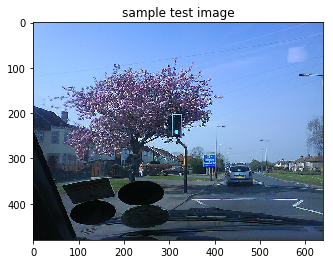

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

original_test_image, preprocessed_test_image = next(iter(test_data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(original_test_image))
plt.title('sample test image')
plt.show()

### Loading the trained Model

In [40]:
% load_ext autoreload
% autoreload 2


encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# The size of the vocabulary.
test_vocab_size = len(test_data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder_model = EncoderCNN(embed_size)
encoder_model.eval()
decoder_model = DecoderRNN(embed_size, hidden_size, test_vocab_size)
decoder_model.eval()

# Load the trained weights.
encoder_model.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder_model.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder_model.to(Dev0)
decoder_model.to(Dev0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (embed): Embedding(9955, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

### Passing the input image sample to encoder to get embedded features and finally passing it to decoder to get the prediction

In [41]:
preprocessed_test_image = preprocessed_test_image.to(Dev0)

# Obtain the embedded image features.
features = encoder_model(preprocessed_test_image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder_model.sample(features)
print('example output:', output)

example output: [0, 3, 33, 30, 39, 3, 910, 39, 3, 228, 33, 18, 1, 1, 1, 1, 86, 6, 251, 498]


### Cleaning the Generated Captions

In [42]:
def clean_captions(out):
    captions_list = []
    last = 0
    
    for index in range(len(out)):
        if out[index] == 1:
            break
        else:
            captions_list.append(test_data_loader.dataset.vocab.idx2word[out[index]])
            
    captions_list = captions_list[1:-1]

    captions = ' '.join(captions_list)
    return captions

In [43]:
captions = clean_captions(output)
print('test sample captions:', captions)

test sample captions: a street sign on a pole on a city street


In [44]:
def get_prediction():
    original_test_image, preprocessed_test_image = next(iter(test_data_loader))
    plt.imshow(np.squeeze(original_test_image))
    plt.title('Test Data Sample Image')
    plt.show()
    preprocessed_test_image = preprocessed_test_image.to(Dev0)
    features = encoder_model(preprocessed_test_image).unsqueeze(1)
    out = decoder_model.sample(features)    
    captions = clean_captions(out)
    print("The Caption Generated by Sequence Model is :", captions)

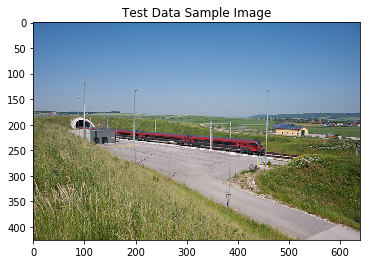

The Caption Generated by Sequence Model is : a train traveling down tracks next to a forest


In [45]:
get_prediction()

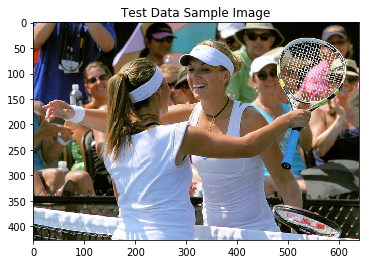

The Caption Generated by Sequence Model is : a man is playing tennis on a tennis court


In [46]:
get_prediction()

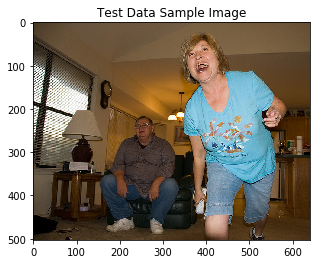

The Caption Generated by Sequence Model is : a man and woman playing a game on a wii


In [47]:
get_prediction()

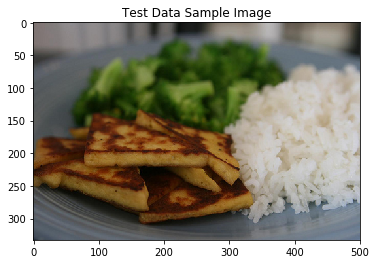

The Caption Generated by Sequence Model is : a plate of food with broccoli , carrots , and other vegetables


In [48]:
get_prediction()